# ************ NOTEBOOK 2 :  MACHINE LEARNING*********** 

# 1 Importation des librairies et jeux de données

In [ ]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
#import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import time, pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV
import re
import warnings
warnings.filterwarnings("ignore")

# 2  Importation des datasets d'entrainement et de test aggrégées 

In [ ]:
X_train_agg=pd.read_csv('X_train_agg.csv')
X_test_agg=pd.read_csv('X_test_agg.csv')

In [ ]:
X_train_agg.shape,X_test_agg.shape

# 3 Preprocessing des bases de données X_train_agg et X_test_agg

In [ ]:
X_train_agg=X_train_agg.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_agg=X_test_agg.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train_agg=X_train_agg.set_index('SK_ID_CURR')
X_test_agg=X_test_agg.set_index('SK_ID_CURR')

In [ ]:
X_train_agg.head()

## 3_1 Modelisation avec X_train_agg comme base de données et création d'un jeu de validation  Xtest.

In [ ]:
data_train=X_train_agg.drop('TARGET',axis=1)


In [ ]:
y=X_train_agg['TARGET']



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_train,y, test_size=0.3, random_state=42,stratify=y)

## 3_2 Analyse de la distribution des données

In [ ]:
#Data Distribution analysis
Des=pd.DataFrame(y_train.value_counts())
Des

In [ ]:
fig = plt.figure(figsize =(4, 3))
sns.countplot(x=y_train,data=X_train_agg)
plt.title('Secured loan& Insecured loan')
plt.savefig('CountChart02.png')
plt.show()

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

In [ ]:
from collections import Counter
sm = SMOTE(random_state=27)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
print('Before sampling class distribution:-',Counter(y_train))
print('After sampling class distribution:-',Counter(y_train_res))

# 4 Modelisation sans optimisation des hyperparametres

## 4_1 Fonctions utiles

In [ ]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output

In [ ]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances=None):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    if feature_importances is not None:
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]

        features = []
        for i in range(20):
            features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)
        plt.show()

# 4_2 Baseline model - Logistic Regression

### 4_2_1-Classe non équilibrée

Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

In [ ]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

### 4_2_2-Classe équilibrée selon le modèle d'oversampling SMOTHE¶

In [ ]:
%%time
ls = LogisticRegression(C = 0.0001, max_iter=100)
ls.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, ls.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, ls.predict(X_test)))

In [ ]:
cf_matrix_roc_auc(ls, y_test, ls.predict(X_test), ls.predict_proba(X_test)[:,1], feature_importances=None)

# 5 Tests comparatifs et selection du meilleur modèle de classification 

In [ ]:
#Predictive Models
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


## 5_1 Evaluation du Gradient-Boosting sans oversampling 

In [ ]:
scale_pos_weight_value=((y_train==0).sum())/((y_train==1).sum())

In [ ]:
#Predictive Models
AdaBoostClassifier_N= AdaBoostClassifier()
LGBMClassifier_N=LGBMClassifier(scale_pos_weight=scale_pos_weight_value)
RandomForestClassifier_N=RandomForestClassifier(class_weight="balanced")
XGBClassifier_N=XGBClassifier(scale_pos_weight=scale_pos_weight_value)  

models = [
          AdaBoostClassifier_N,
          LGBMClassifier_N,
          RandomForestClassifier_N,
          XGBClassifier_N                   
        ]

In [ ]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)
    
#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)


In [ ]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)
    
#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

In [ ]:
base_models

## 5_2 Evaluation du Gradient-Boosting en oversampling avec l'algorithme SMOTE

Nous allons comparer une nouvelle fois nos modèles, cette fois-ci l'entrainement se fera avec les données SMOTE.

In [ ]:
#Predictive Models
AdaBoostClassifier_S=AdaBoostClassifier()
LGBMClassifier_S=LGBMClassifier(scale_pos_weight=scale_pos_weight_value)
RandomForestClassifier_S=RandomForestClassifier(class_weight="balanced")
XGBClassifier_S=XGBClassifier(scale_pos_weight=scale_pos_weight_value) 

models = [
          AdaBoostClassifier_S,
          LGBMClassifier_S,
          RandomForestClassifier_S,
          XGBClassifier_S 
         ]

In [ ]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model,X_train_res,X_test,y_train_res,y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)
    
#Initialise data of lists
base_models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models_res.sort_values('AUC', ascending=False, inplace=True)
# We add suffixe _Res in order to make difference between models
base_models_res['Model']=np.where(base_models_res['AUC']>0,base_models_res['Model']+'_Res',base_models_res['Model'])


In [ ]:
base_models_res

# 6 Selection du modèle de Classification le plus performant.

### LGBMClassifier reste le modèle de classification le  "plus performant" selon le couple métrique/temps.

# 7 Selection des meilleures variables indépendantes - Recursive Feature Elimination

##### Objectif:Pour augmenter le score du modèle, nous devons supprimer les features qui sont récursives. La suppression des features recursives réduit le coût de calcul et augmente l'efficacité.

La selection des meilleurs features peut s'effectuer avec LGBMClassifier qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 228 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [ ]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

In [ ]:
#print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

In [ ]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

In [ ]:
#Plot number of features vs CV scores
step=5
plt.figure(figsize=(20, 10))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of features tested (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')
plt.show()

RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également le plot ci-dessus.

In [ ]:
#X_data is very important to implement the feature importance plot...
X_data = X_train.loc[:, X_train.columns[rfecv.get_support()]]
X_data.shape

In [ ]:
X_target=y_train

In [ ]:
y_data=X_test.loc[:, X_test.columns[rfecv.get_support()]]
y_data.shape

# 8 Sauvegarde de la  dataset X_data avec les n variables selectionnés.


In [ ]:
#Merge operation with TARGET before save this reduced sample
X_table = X_data.merge(X_target, left_index=True, right_index=True)

In [ ]:
X_table.shape

In [ ]:
X_table


In [ ]:
X_table.to_csv('X_table.csv',index=True)

# 9  Mise à jour du jeux de Test agrégé=X_test_agg 

#### Ce jeu de donnéepouura servir de Test pour le modèle qui sera déployé

In [ ]:
X_test_agg

In [ ]:
X_tests_agg = X_test_agg.loc[:, X_test_agg.columns[rfecv.get_support()]]

In [ ]:
X_tests_agg

# 10 Sauvegarde des jeux de données de base :X_data et X_tests_agg

Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 88 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [ ]:
X_table.to_csv('X_table.csv',index=True)

In [ ]:
X_tests_agg.to_csv('X_tests_cloud.csv',index=True)

In [ ]:
X_table.shape,X_tests_agg.shape

# 11 Preprocessing the optimized rfecvDataset.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# standardize the feature variables 

scaler = StandardScaler()
X_trains = scaler.fit_transform(X_data)

In [ ]:
X_trains

In [ ]:
X_tests = scaler.fit_transform(y_data)

In [ ]:
X_tests

In [ ]:
X_trains.shape,X_tests.shape,y_train.shape,y_test.shape

In [ ]:
def train_models(model, X_trains, X_tests, y_train, y_test):
    models = [
          #Ensemble methods
           AdaBoostClassifier(),
           LGBMClassifier(scale_pos_weight=scale_pos_weight_value),
           RandomForestClassifier(class_weight="balanced"),
           XGBClassifier(scale_pos_weight=scale_pos_weight_value)  
          
          ]

    model.fit(X_trains, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_tests)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_tests)),
      'Precision': precision_score(y_test, model.predict(X_tests)),
      'Recall': recall_score(y_test, model.predict(X_tests)),
      'F1': f1_score(y_test, model.predict(X_tests))
      }
          
    return output

In [ ]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_trains, X_tests, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)
    
#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)


In [ ]:
#Models performance with features selection
models_rfe

In [ ]:
###Reminder before… features selection
base_models

#### Avec la selection des meilleures variables indépendantes le modèle de classification LGBMClassifier reste le modèle le "plus performant" selon le couple métrique/temps.

# 12 Modelisation avec optimisation des hyperparamètres

## 12_1 Gestion de la fonction cout

##### Objectif: Les métriques métiers sont des métriques quantifiables utilisées pour suivre et évaluer un objectif métier spécifique.

La gestion de la  fonction coût sera déterminée par l'analyse des erreurs de prédiction.
FP (False Positive) : les cas où la prédiction est positive, mais où la valeur réelle est négative.

Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé.

FN (False Negative) : les cas où la prédiction est négative, mais où la valeur réelle est positive.

Perte réelle si le crédit client accepté se transforme en défaut de paiement.

Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.

L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision selon les formules suivantes: 
                           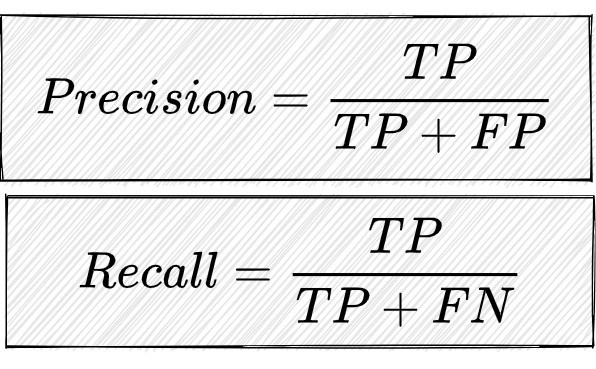
                           
                           
 
 


 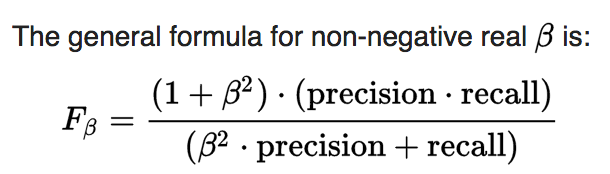

Fbeta,L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir par le coefficient Beta (β).
Beta=1 soit le métrique F1_score qui nous permet d'estimer le coût moyen d'un défaut de remboursement d'un pret, et le coût d'opportunité d'un client refusé par erreur.
Ces objectifs métiers sont méconnues  à ce stade du projet, nous allons donc les estimer de manière aléatoire selon l'idée suivante:
L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser le Recall soit fixer un Beta>1

On pourra donc tester dans l'intervalle 2 et 4 ,soir Beta=[2,3,4].

In [ ]:
def custom_score(y_true, y_pred, beta) :
    '''function penalize fp and fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore

In [ ]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    print("Ratio_False:{0:.2}".format(FP/FN))
    return FP, FN ,cm

## 12_2 Tuning des hyperparamètres du modèle de classification LGBMClassifier avec l'algorithme Hyperopt

##### Le réglage des hyperparamètres peut être un peu fastidieux. GridSearch et RandomSearch sont deux approches de base pour en automatiser certains aspects. GridSearch est assez complet mais d'un autre côté rigide et lent. Rigide en explorant uniquement un ensemble spécifique de valeurs de paramètres exactes, et lent en essayant chaque combinaison, qui devient rapidement un grand ensemble. RandomSearch explore les variantes plus rapidement mais pas de manière très systématique, et se concentre également sur une spécification stricte similaire de l'espace de recherche.
##### Une autre approche est utilisée par les frameworks d'optimisation tels que Hyperopt. 
##### Avantage ,il semble combiner certains des meilleurs des deux, avec des initialisations aléatoires conduisant à une recherche plus guidée vers les domaines prometteurs. Il utilise également une définition plus détendue de l'espace de recherche sous forme de distributions par rapport aux valeurs exactes.

In [ ]:
from hyperopt import STATUS_OK,Trials,fmin,hp,tpe

We will use 7 hyperparameters of the LGBM algorithm which are n_estimators,max_depth,learning rate,num_leaves,reg_alpha,reg_lambda and min_child_weight.

In [ ]:
#Define Parameter Space for Optimization
space={'n_estimators':hp.quniform('n_estimators',100,200,1),
       'max_depth':hp.quniform('max_depth',2,8,1),
       'learning_rate':hp.loguniform("learning_rate",-4,-1),
       'num_leaves':hp.quniform('num_leaves',30,50,1),
       'reg_alpha':hp.quniform('reg_alpha',1.1,1.5,0.1),
       'reg_lambda':hp.uniform('reg_lambda',1.1,1.5),
       'min_child_weight':hp.quniform('min_child_weight',0,10,1)
      }

#### Nous avons défini différentes valeurs dans les hyperparamètres sélectionnés ci-dessus. Ensuite, nous définirons la fonction objectif.

# 13 Implémentation du modèle de classification généralisé et  évalué par le métrique Roc_Auc_Score

In [ ]:
#lightGBM

Model_Auc=[]
Taux_False_Auc=[]
Ratio_False_Auc=[]
Result_Auc=[]
def objective(params,eval_metric='roc_auc'):
        #Objective function to be minimized
        #Hyperopt will seek to minimize the loss returned by this function.

        # we use this params to create a new LGBM Regressor

        params={
                 'n_estimators':int(params['n_estimators']),
                 'max_depth':int(params['max_depth']),
                 'learning_rate':params['learning_rate'],
                 'num_leaves':int(params['num_leaves']),
                 'reg_alpha':params['reg_alpha'],
                 'reg_lambda':params['reg_lambda'],
                 'min_child_weight':params['min_child_weight']
               }

                
        model= LGBMClassifier(**params)
        if eval_metric == 'roc_auc': 
            score = cross_val_score(model, X_trains, y_train, scoring='roc_auc', cv=10).mean()

        loss = 1 - score    
        return {'loss': loss, 'params': params, 'status': STATUS_OK}
#Fine Tune du Model        
trials=Trials()# Initialize trials object
best=fmin(fn=objective,  # function to optimize
      space=space,
      algo=tpe.suggest,# optimization algorithm,hyperopt will select its parameters automaticallay
      max_evals=10, # maximum number of iterations
      trials=trials # logging
     )
Result_Auc.append(best)
#Initialisation du model
lgbm_clf_auc=LGBMClassifier(n_estimators=int(best['n_estimators']),
                     max_depth=int(best['max_depth']),
                     learning_rate=best['learning_rate'],
                     reg_alpha=best['reg_alpha'],
                     reg_lambda=best['reg_lambda'],
                     min_child_weight=best['min_child_weight'])
# Entrainement du modèle
lgbm_clf_auc.fit(X_trains, y_train)
    
#Transfert du modèle entrainé avec ses hyperparamètres avec le métrique Eval="custom_score" dans la variable modeliz
modeliz=lgbm_clf_auc
output = {
  'AUC': roc_auc_score(y_test, modeliz.predict_proba(X_tests)[:,1]),
  'Precision': precision_score(y_test, modeliz.predict(X_tests)),
  'Recall': recall_score(y_test, modeliz.predict(X_tests)),
  'F1': f1_score(y_test, modeliz.predict(X_tests))
    }
# Transfert des variables et résultats dans les listes
Model_Auc.append(modeliz)
#Calcul et Affichage de FP,FN,cm
FP,FN,cm =cost_false(modeliz,y_test, X_tests)
CM2=cm
print(cm)
print(output)
    

## 13_1 Affichage détaillé de la Matrice de confusion du meilleur modèle de classification Objectif métier selectionné

In [ ]:
cm_matrix = pd.DataFrame(data=CM2, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## 13_2 Affichage des résultats collecté en exploration empirique des objectifs métier avec hypothèse d'optimisation du Recall

In [ ]:
print(Model_Auc)

## 13_3Construction du modèle de classification LGBMClassifier à déployer

In [ ]:
%%time
lgbm_clf_auc=Model_Auc
lgbm_clf_auc.fit(X_trains, y_train)

## 13_4 Sauvegarde du modèle de Classification finalisé 

In [ ]:
# save the model to disk
filename = 'finalized_model_auc.pkl'
pickle.dump(lgbm_clf_auc, open(filename, 'wb'))

## 13_5 Evaluation du Roc_Auc_Score et Rapport de Classification du modèle LGBMClassifier

In [ ]:
roc_auc = roc_auc_score(y_test, lgbm_clf_auc.predict_proba(X_tests)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lgbm_clf_auc.predict(X_tests)))

## 13_6 Courbe Roc_Auc et Histogramme des variables importantes du modèle¶

In [ ]:
cf_matrix_roc_auc(lgbm_clf_auc, y_test,lgbm_clf_auc.predict(X_tests), lgbm_clf_auc.predict_proba(X_tests)[:,1],feature_importances=ranking[ranking.RANK == 1]['Features'].to_list())

## 13_7 Liste détaillé et ordonnée des features importants du modèle de classification

In [ ]:
#Check list features importance 
sorted_idx = np.argsort(lgbm_clf_auc.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm_clf_auc.feature_importances_[index]]) 

# 14 Cas d'etude Risk Crédit avec Objectifs Métier à solutionner

## 14_1 Analyse comparative  des modèles de classification en fonction de l'objectif métier tributaire du métrique d'evaluation Custom_Score =(1-Fbeta_score) pour beta=2,3,4 et 5.

### Sans objectif business précis nous allons analyser la variation de la réduction du Recall en fonction de Beta et selection le modèle ayant un meilleur ratio FP/FN

In [ ]:
CM=[]
Model=[]
Result=[]
Beta=[]
Eval_model=[]
myList=[2,3,4,5,6]
for beta in myList:
#define objective function   
    def hyperparameter_tuning(params,beta=beta,eval_metric='custom_score'):
        
        #Hyperopt will seek to minimize the loss returned by this function.

        # we use this params to create a new LGBM Regressor
        
        params={
                 'n_estimators':int(params['n_estimators']),
                 'max_depth':int(params['max_depth']),
                 'learning_rate':params['learning_rate'],
                 'num_leaves':int(params['num_leaves']),
                 'reg_alpha':params['reg_alpha'],
                 'reg_lambda':params['reg_lambda'],
                 'min_child_weight':params['min_child_weight']
               }

                
        model= LGBMClassifier(**params)
        if eval_metric == 'custom_score': 
            y_pred = cross_val_predict(model, X_trains, y_train, method='predict',cv=10)
            score = custom_score(y_train, y_pred,beta)

        loss = 1 - score 
        
        return {'loss': loss, 'params': params, 'status': STATUS_OK}
      
#Fine Tune du Model        
    trials=Trials()# Initialize trials object
    best=fmin(fn=hyperparameter_tuning,  # function to optimize
          space=space,
          algo=tpe.suggest,# optimization algorithm,hyperopt will select its parameters automaticallay
          max_evals=10, # maximum number of iterations
          trials=trials # logging
         )
    Result.append(best)
#Initialisation du model
    lgbm_clf_beta=LGBMClassifier(n_estimators=int(best['n_estimators']),
                     max_depth=int(best['max_depth']),
                     learning_rate=best['learning_rate'],
                     reg_alpha=best['reg_alpha'],
                     reg_lambda=best['reg_lambda'],
                     min_child_weight=best['min_child_weight'])
    
# Entrainement du modèle
    lgbm_clf_beta.fit(X_trains, y_train)
       
#Transfert du modèle entrainé avec ses hyperparamètres avec le métrique Eval="custom_score" dans la variable modeliz
    modeliz=lgbm_clf_beta
    output = {
  'AUC': roc_auc_score(y_test, modeliz.predict_proba(X_tests)[:,1]),
  'Precision': precision_score(y_test, modeliz.predict(X_tests)),
  'Recall': recall_score(y_test, modeliz.predict(X_tests)),
  'F1': f1_score(y_test, modeliz.predict(X_tests))
    }
# Transfert des variables et résultats dans les listes
    Beta.append(beta)
    Model.append((modeliz,beta))
    Eval_model.append((output,beta))
# Affichage de Beta
    print("beta=",beta)
#Calcul et Affichage de FP,FN,cm
    FP,FN,cm =cost_false(modeliz,y_test, X_tests)
#Transfert des tuples matrice de confusion et beta vers la liste CM
    CM.append((cm,beta))    
    print("CM=",cm)
    print(output)
 
                 
      

# 14.2Réentrainement du modèle afin de mettre en lumière la problématique de l'instabilité du modèle au réentrainement.

In [ ]:
CM1=[]
Model1=[]
Result1=[]
Beta1=[]
Eval_model1=[]
myList=[2,3,4,5,6]
for beta in myList:
#define objective function   
    def hyperparameter_tuning(params,beta=beta,eval_metric='custom_score'):
        
        #Hyperopt will seek to minimize the loss returned by this function.

        # we use this params to create a new LGBM Regressor
        
        params={
                 'n_estimators':int(params['n_estimators']),
                 'max_depth':int(params['max_depth']),
                 'learning_rate':params['learning_rate'],
                 'num_leaves':int(params['num_leaves']),
                 'reg_alpha':params['reg_alpha'],
                 'reg_lambda':params['reg_lambda'],
                 'min_child_weight':params['min_child_weight']
               }

                
        model= LGBMClassifier(**params)
        if eval_metric == 'custom_score': 
            y_pred = cross_val_predict(model, X_trains, y_train, method='predict',cv=10)
            score = custom_score(y_train, y_pred,beta)

        loss = 1 - score 
        
        return {'loss': loss, 'params': params, 'status': STATUS_OK}
      
#Fine Tune du Model        
    trials=Trials()# Initialize trials object
    best=fmin(fn=hyperparameter_tuning,  # function to optimize
          space=space,
          algo=tpe.suggest,# optimization algorithm,hyperopt will select its parameters automaticallay
          max_evals=10, # maximum number of iterations
          trials=trials # logging
         )
    Result1.append(best)
#Initialisation du model
    lgbm_clf_beta1=LGBMClassifier(n_estimators=int(best['n_estimators']),
                     max_depth=int(best['max_depth']),
                     learning_rate=best['learning_rate'],
                     reg_alpha=best['reg_alpha'],
                     reg_lambda=best['reg_lambda'],
                     min_child_weight=best['min_child_weight'])
    
# Entrainement du modèle
    lgbm_clf_beta1.fit(X_trains, y_train)
       
#Transfert du modèle entrainé avec ses hyperparamètres avec le métrique Eval="custom_score" dans la variable modeliz
    modeliz1=lgbm_clf_beta1
    output1 = {
  'AUC': roc_auc_score(y_test, modeliz1.predict_proba(X_tests)[:,1]),
  'Precision': precision_score(y_test, modeliz1.predict(X_tests)),
  'Recall': recall_score(y_test, modeliz1.predict(X_tests)),
  'F1': f1_score(y_test, modeliz1.predict(X_tests))
    }
# Transfert des variables et résultats dans les listes
    Beta1.append(beta)
    Model1.append((modeliz1,beta))
    Eval_model1.append((output1,beta))
# Affichage de Beta
    print("beta=",beta)
#Calcul et Affichage de FP,FN,cm
    FP1,FN1,cm1 =cost_false(modeliz1,y_test, X_tests)
#Transfert des tuples matrice de confusion et beta vers la liste CM
    CM1.append((cm1,beta))    
    print(cm1)
    print(output1)
 
                 
      

## 14.3 Selection du modèle qui a le plus grand recall

In [ ]:
Recall=[]
myList=[2,3,4,5,6]
for j in range(len(myList)):
    tp, tn, fp, fn = CM1[j][0].ravel()
    recall = tp / (tp + fn)
    Recall.append((recall,j))
max_recall = max(Recall, key=lambda p:p[0])[0]
print('max_recall=',max_recall)
for j in range(len(myList)):
    if Recall[j][0]==max_recall:
        print('j=',j)
        idx=j
        print('beta=',Beta1[j])
    
    
    

## 14_4 Bilan de l'impact des objectifs métier sur le modele de classification

## Affichage détaillé de la Matrice de confusion du meilleur modèle de classification Objectif métier selectionné.

In [ ]:
cm_matrix2 = pd.DataFrame(data=CM1[idx][0], columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix2, annot=True, fmt='d', cmap='YlGnBu')

## 14_5 Affichage des paramètre du meilleur modèle selectionné  en exploration empirique des objectifs métier avec hypothèse d'optimisation du Recall

In [ ]:
print(Model1[idx][0])

## 14_6 Choix du meilleur modèle Objectif métier avec Optimisation du Recall , Beta=5

In [ ]:
%%time
lgbm_clf_cust=Model1[idx][0]
lgbm_clf_cust.fit(X_trains, y_train)


## 14_7 Sauvegarde du modèle de classification finalisé avec métrique métier Beta=5

In [ ]:
# save the model to disk
filename = 'finalized_model_cust.pkl'
pickle.dump(lgbm_clf_cust, open(filename, 'wb'))

## 14_8 Evaluation du Roc_Auc_Score et Rapport de Classification du modèle Objectif métier avec choix d'un Bera empirique

In [ ]:
roc_auc = roc_auc_score(y_test, lgbm_clf_cust.predict_proba(X_tests)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lgbm_clf_cust.predict(X_tests)))

## 14_9  Courbe  Roc_Auc et Histogramme des variables importantes avec métrique métier fixé avec choix d'un Beta empirique

In [ ]:
cf_matrix_roc_auc(lgbm_clf_cust, y_test,lgbm_clf_cust.predict(X_tests), lgbm_clf_cust.predict_proba(X_tests)[:,1], feature_importances=ranking[ranking.RANK == 1]['Features'].to_list())

## 14_10 Liste des features importants du modele de Classification Objectif métier

In [ ]:
#Check list features importance 
sorted_idx = np.argsort(lgbm_clf_cust.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm_clf_cust.feature_importances_[index]]) 

# 15 Conclusion

A partir d'une baseline implémentée par un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.62 avec rééquilibrage (SMOTE) des données. La suite de l'étude a été déroulée vers 4 algorithmes plus complexes de gradient boosting implémentés par LGBMClassifier,AdaBoostClassifier,XGBClassifier et RandomForestClassifier.
Nous avons pu évaluer les performances de ces algorithmes par une sélection de features, à l'origine > 300.Après RFECV nous avons finalement obtenu  88 meilleures features. LightGbm ressort comme étant l'algorithme de classification  le plus rapide et  le plus performant sur la métrique classique de l'AUC, il a donc été choisi pour l'optimisation des Hyperparamètres (Hyperopt).

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. Au final la métrique métier permet de pénaliser légèrement mieux les erreurs du modèle mais nous avons mis en évidence un comportement du modèle qui ne nous permet pas de certifier la fiabilité du modèle car nous avons constaté une instabilité notoire  au rédemarrage.


Enfin,pénaliser les erreurs de prédiction revient à donner un score d'importance à certaine feature en fonction de leur utilité à prédire la variable cible.
Par conséquent nous aurons un scoring different d'une optimisation à une autre de notre modèle.